In [1]:
import builtins
from datetime import datetime


def print(*args, **kwargs):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    builtins.print(f"[{timestamp}] ", *args, **kwargs)

In [2]:
import random

import numpy as np
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm

In [3]:
ds = load_dataset("microsoft/cats_vs_dogs")

In [4]:
from datasets import DatasetDict

train_test_split = ds["train"].train_test_split(test_size=0.2, seed=42)
test_valid_split = train_test_split["test"].train_test_split(test_size=0.5, seed=42)

# Create new dataset dictionary
dataset = DatasetDict({
    "train": train_test_split["train"],
    "validation": test_valid_split["train"],
    "test": test_valid_split["test"]
})

In [5]:
class cats_vs_dogs(Dataset):
    def __init__(self, dataset, transform, stage="train"):
        self.dataset = dataset
        self.transform = transform
        self.stage = stage
    def __len__(self):
        return len(self.dataset[self.stage])
        
    def __getitem__(self, idx):
        image = self.dataset[self.stage][idx]['image'].convert("RGB")
        label = self.dataset[self.stage][idx]['labels']
        
        label = torch.tensor(label).float()
        image = self.transform(image)
        
        return image, label

In [6]:
transform_config = {
    'train': transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                             std=[0.26862954, 0.26130258, 0.27577711])
    ])
}

In [7]:
train_dataset = cats_vs_dogs(dataset, transform_config["train"], stage="train")
test_dataset = cats_vs_dogs(dataset, transform_config["test"], stage="test")
validation_dataset = cats_vs_dogs(dataset, transform_config["test"], stage="validation")

In [8]:
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [9]:
from torch import nn


class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        x = x.squeeze(1)
        return x

In [10]:
class VGG(nn.Module):
    def __init__(self, num_classes, dropout=0.5):
        super().__init__()
        self.features = nn.Sequential(
            *self.cnn_block(3, 64, 2),
            *self.cnn_block(64, 128, 2),
            *self.cnn_block(128, 256, 3),
            *self.cnn_block(256, 512, 3),
            *self.cnn_block(512, 512, 3),
        )              
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(4096, num_classes),
        )
        
    def cnn_block(self, in_channels, out_channels, nr_layers):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU(inplace=True))
        
        for _ in range(nr_layers - 1):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU(inplace=True))
        
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        return layers
    
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        x = x.squeeze(1)
        return x

In [11]:
import torch
import torch.nn as nn

# 1. Patch Embedding: Split image into non-overlapping patches and project them to an embedding space.
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        """
        img_size: size of the input image (assumed square).
        patch_size: size of each patch.
        in_chans: number of input channels (3 for RGB).
        embed_dim: dimension of the embedding space for each patch.
        """
        super().__init__()
        self.patch_size = patch_size
        # This convolution uses kernel size and stride equal to patch_size.
        # It converts the image into a grid of patches and projects each patch into an embedding vector.
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        # Calculate the number of patches (e.g., for 224x224 with 16x16 patches, we have 14x14 = 196 patches)
        self.num_patches = (img_size // patch_size) ** 2

    def forward(self, x):
        # x has shape (batch_size, 3, 224, 224)
        x = self.proj(x)  # Now shape becomes (batch_size, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # Flatten the height and width dimensions; shape: (batch_size, embed_dim, num_patches)
        x = x.transpose(1, 2)  # Transpose to shape: (batch_size, num_patches, embed_dim)
        return x

# 2. MLP Block: A simple feed-forward network used inside the mixer layers.
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, dropout=0.0):
        """
        in_features: size of each input vector.
        hidden_features: hidden layer dimension.
        out_features: size of the output vector.
        dropout: dropout rate applied after each linear layer.
        """
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)  # First linear layer
        self.act = nn.GELU()  # Activation function
        self.fc2 = nn.Linear(hidden_features, out_features)  # Second linear layer
        self.drop = nn.Dropout(dropout)  # Dropout layer for regularization
        
    def forward(self, x):
        x = self.fc1(x)   # Apply first linear layer
        x = self.act(x)   # Apply GELU activation
        x = self.drop(x)  # Apply dropout
        x = self.fc2(x)   # Apply second linear layer
        x = self.drop(x)  # Apply dropout again
        return x

# 3. Mixer Layer: Contains both token mixing and channel mixing MLPs with residual connections.
class MixerLayer(nn.Module):
    def __init__(self, num_patches, embed_dim, token_mlp_dim, channel_mlp_dim, dropout=0.0):
        """
        num_patches: number of patches (tokens) per image.
        embed_dim: dimension of each patch embedding.
        token_mlp_dim: hidden dimension for the token-mixing MLP.
        channel_mlp_dim: hidden dimension for the channel-mixing MLP.
        dropout: dropout rate for the MLPs.
        """
        super().__init__()
        # Normalization before token mixing
        self.norm1 = nn.LayerNorm(embed_dim)
        # Token mixing MLP works across the tokens dimension. It first transposes the input.
        self.token_mixing = Mlp(num_patches, token_mlp_dim, num_patches, dropout)
        
        # Normalization before channel mixing
        self.norm2 = nn.LayerNorm(embed_dim)
        # Channel mixing MLP works on each token independently along the channel dimension.
        self.channel_mixing = Mlp(embed_dim, channel_mlp_dim, embed_dim, dropout)
        
    def forward(self, x):
        # x shape: (batch_size, num_patches, embed_dim)
        
        # ---- Token Mixing ----
        y = self.norm1(x)  # Normalize across the embedding dimension
        # Transpose to swap tokens and channels: shape becomes (batch_size, embed_dim, num_patches)
        y = y.transpose(1, 2)
        y = self.token_mixing(y)  # Mix information across the tokens (spatial locations)
        # Transpose back to original shape: (batch_size, num_patches, embed_dim)
        y = y.transpose(1, 2)
        # Add residual connection
        x = x + y
        
        # ---- Channel Mixing ----
        y = self.norm2(x)  # Normalize before channel mixing
        y = self.channel_mixing(y)  # Mix information along the channels for each token
        # Add residual connection
        x = x + y
        return x

# 4. MLP-Mixer Model: Stack the patch embedding, a series of Mixer layers, and the classification head.
class MLPMixer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1, embed_dim=768, depth=12, dropout=0.0):
        """
        img_size: size of the input image.
        patch_size: size of each patch.
        in_chans: number of image channels.
        num_classes: number of output classes (2 for cats vs. dogs).
        embed_dim: dimension of patch embeddings.
        depth: number of Mixer layers to stack.
        dropout: dropout rate for the MLP blocks.
        """
        super().__init__()
        # Step 1: Patch Embedding
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        
        # Compute the number of patches (tokens)
        num_patches = self.patch_embed.num_patches  # For 224x224 and 16x16 patches, num_patches = 196
        
        # For the token-mixing MLP, the hidden dimension is set to the number of patches.
        token_mlp_dim = num_patches
        # For the channel-mixing MLP, the hidden dimension is 4 times the embedding dimension.
        channel_mlp_dim = embed_dim * 4
        
        # Step 2: Stack Mixer layers
        self.mixer_layers = nn.Sequential(*[
            MixerLayer(num_patches, embed_dim, token_mlp_dim, channel_mlp_dim, dropout)
            for _ in range(depth)
        ])
        
        # Step 3: Final normalization layer
        self.norm = nn.LayerNorm(embed_dim)
        
        # Step 4: Classification head.
        # After processing through Mixer layers, we perform global average pooling over tokens
        # and then project the resulting vector to the number of classes.
        self.classifier = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, 3, 224, 224)
        
        # Convert image to patch embeddings (tokens)
        x = self.patch_embed(x)  # Shape: (batch_size, num_patches, embed_dim)
        
        # Process the tokens through the Mixer layers
        x = self.mixer_layers(x)
        
        # Apply final layer normalization
        x = self.norm(x)
        
        # Global average pooling over the token dimension
        x = x.mean(dim=1)  # Now shape: (batch_size, embed_dim)
        
        # Final classifier to obtain logits for each class (cats vs. dogs)
        x = self.classifier(x)  # Shape: (batch_size, num_classes)
        return x.squeeze(1)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
model = AlexNet(num_classes=1)
# Dummy input tensor of size (batch_size, channels, height, width)
input_tensor = torch.randn(2, 3, 224, 224)
output = model(input_tensor)
print(output)

[2025-02-10 10:47:35]  tensor([0.0180, 0.0210], grad_fn=<SqueezeBackward1>)


In [14]:
model = VGG(num_classes=1, dropout=0.2)
# Dummy input tensor of size (batch_size, channels, height, width)
input_tensor = torch.randn(2, 3, 224, 224)
output = model(input_tensor)
print(output)

[2025-02-10 10:47:36]  tensor([-0.0038, -0.0046], grad_fn=<SqueezeBackward1>)


In [15]:
model = MLPMixer(img_size=224, patch_size=16, in_chans=3, num_classes=1, embed_dim=768, depth=12, dropout=0.1)
input_tensor = torch.randn(2, 3, 224, 224)
output = model(input_tensor)
print(output)

[2025-02-10 10:47:36]  tensor([-0.0838, -0.1307], grad_fn=<SqueezeBackward1>)


In [16]:
def initialize_weights(m):
    """
    Initializes the weights of the MLP-Mixer model.
    This function is applied recursively to all layers in the model.
    """
    if isinstance(m, nn.Linear):
        # Xavier Normal Initialization for Linear layers (MLPs)
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)  # Initialize bias to zero for stability
    
    elif isinstance(m, nn.LayerNorm):
        # Initialize LayerNorm (scale=1, bias=0)
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    
    elif isinstance(m, nn.Conv2d):
        # Kaiming Normal Initialization for the Patch Embedding layer (Conv2d)
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(initialize_weights)
model.to(device)

MLPMixer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (mixer_layers): Sequential(
    (0): MixerLayer(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (token_mixing): Mlp(
        (fc1): Linear(in_features=196, out_features=196, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=196, out_features=196, bias=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (channel_mixing): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
    )
    (1): MixerLayer(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (token_mixing): Mlp(
        (fc1): Linear(in_features=196, out_features=196, bias

In [17]:
from torch.nn import BCEWithLogitsLoss

criterion = BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=5,
    T_mult=1,
    eta_min=5e-4,
)
model_config = {
    "lr": 1e-2,
    "eta_min": 5e-4,
    "weight_decay": 5e-4,
}

In [18]:
from sklearn.metrics import confusion_matrix as cf_mx
import seaborn as sns

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

def validation_method(criterion, model, val_loader, confusion_matrix=False):
    ### VALIDATING
    model.eval()
    validation_loss = 0.0
    all_labels = []  # Ground truth labels for validation
    all_preds = []  # Predictions for validation
    
    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            output = model(images)  # Forward pass (logits)
            loss = criterion(output, labels)  # Compute validation loss
            validation_loss += loss.item()

            # Convert logits to probabilities and apply threshold
            probs = torch.sigmoid(output)
            preds = (probs > 0.5).float()

            # Store for statistics
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    val_loss = validation_loss / len(val_loader)  # Average validation loss
    
    # Compute validation statistics
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_precision = precision_score(all_labels, all_preds, zero_division=0)
    val_recall = recall_score(all_labels, all_preds, zero_division=0)
    val_f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    # Compute confusion matrix if requested
    if confusion_matrix:
        conf_matrix = cf_mx(all_labels, all_preds)
        plot_confusion_matrix(conf_matrix)
    
    return val_accuracy, val_f1, val_loss, val_precision, val_recall

In [19]:
from matplotlib import pyplot as plt
import copy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time


def training_method(model, criterion, optimizer, scheduler, train_loader, val_loader, model_config, num_epochs=50, patience=5, delta = 0.02, loss_procentage_improvement=10, model_name="vgg"):
    train_losses = []  # List to store training losses
    val_losses = []  # List to store validation losses
    val_accuracies = []  # List to store validation accuracies
    val_precisions = []  # List to store validation precisions
    val_recalls = []  # List to store validation recalls
    val_f1s = []  # List to store validation F1-scores
    learning_rates = [] # List to store learning rate progression

    best_val_loss = float('inf')  # Initialize the best validation loss
    initial_loss = float('inf')
    best_model = None  # Store the best model
    epochs_without_improvement = 0  # Track epochs without improvement

    for epoch in range(num_epochs):
        start_time = time.time()
        ### TRAINING
        model.train()
        training_loss = 0.0
        for batch_idx, batch in enumerate(train_loader):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Reset gradients
            output = model(images)  # Forward pass (logits)
            loss = criterion(output, labels)  # Compute loss
            loss.backward()  # Backpropagation
            
            optimizer.step()  # Update weights
            training_loss += loss.item()  # Accumulate loss
            
            if batch_idx % (len(train_loader) // 4) == 0 and batch_idx != 0:
                print(f"[{epoch}, {batch_idx}/{len(train_loader)}] Loss: {training_loss / batch_idx:.4f}")
        
        train_loss = training_loss / len(train_loader)  # Average training loss
        train_losses.append(train_loss)

        val_accuracy, val_f1, val_loss, val_precision, val_recall = validation_method(criterion, model, val_loader)

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        
        if epoch == 1:
            initial_loss = val_loss

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)  # Save the best model
            epochs_without_improvement = 0  # Reset counter
            print(f"New best model with Loss: {val_loss:.4f} at epoch {epoch + 1}")
        elif val_loss < best_val_loss + delta:
            print(f"Validation loss did not improve significantly")            
        else:
            epochs_without_improvement += 1
            print(f"Validation loss did not improve for {epochs_without_improvement} epoch(s).")
            # Stop training if validation loss does not improve for 'patience' epochs
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch + 1}. Best Loss: {best_val_loss:.4f}")
                break  # Exit training loop


        # Step the learning rate scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']  # Get the current learning rate
        learning_rates.append(current_lr)
        end_time = time.time()

        print(f"\nEpoch {epoch + 1}/{num_epochs} - "
              f"Training Loss: {train_loss:.4f} - "
              f"Validation Loss: {val_loss:.4f} - "
              f"Accuracy: {val_accuracy:.4f} - "
              f"Precision: {val_precision:.4f} - "
              f"Recall: {val_recall:.4f} - "
              f"F1 Score: {val_f1:.4f} - "
              f"Time: {end_time - start_time:.2f} - "
              f"Lr: {current_lr:.2e}")

    print('Training finished!')
    
    # save the model only if the best loss is lower than the first initial loss ( to see that the model actually improved with 10% loss )
    if best_val_loss < (100 - loss_procentage_improvement) * initial_loss:
        # Init plot&model save path
        plt_save_path = f"models/{model_name}"
        for key, value in model_config.items():
            plt_save_path += key + "=" + str(value) + "+"
        plt_save_path = plt_save_path[:-1] + ".png"
        model_path = plt_save_path[:-4] + ".pt"
        torch.save(best_model.state_dict(), model_path)
        print(f"Best model with Loss: {best_val_loss:.4f} saved.")
        print(f"Model saved to {model_path}")

        # Plotting the losses and validation metrics over epochs
        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        
        plt.subplot(3, 1, 2)
        plt.plot(val_accuracies, label='Accuracy')
        plt.plot(val_precisions, label='Precision')
        plt.plot(val_recalls, label='Recall')
        plt.plot(val_f1s, label='F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('Metric')
        plt.title('Validation Metrics')
        plt.legend()
        
        plt.subplot(3, 1, 3)
        plt.plot(learning_rates, label='Learning Rate')
        plt.xlabel("Epochs")
        plt.ylabel("Learning Rate")
        plt.title("Learning Rate Progression")
        plt.legend()
    
        plt.tight_layout()
        plt.savefig(plt_save_path)
        plt.show()
    
    else:
        print(f"Model wasn't saved because it didn't improve: {loss_procentage_improvement}%")
    
    return best_model

[2025-02-10 10:40:39]  [0, 292/1171] Loss: 0.7064
[2025-02-10 10:41:32]  [0, 584/1171] Loss: 0.6895
[2025-02-10 10:42:26]  [0, 876/1171] Loss: 0.6819
[2025-02-10 10:43:21]  [0, 1168/1171] Loss: 0.6740
[2025-02-10 10:43:32]  New best model with Loss: 0.6526 at epoch 1
[2025-02-10 10:43:32]  
Epoch 1/1 - Training Loss: 0.6734 - Validation Loss: 0.6526 - Accuracy: 0.6224 - Precision: 0.6643 - Recall: 0.4784 - F1 Score: 0.5562 - Time: 227.25 - Lr: 9.09e-03
[2025-02-10 10:43:32]  Training finished!
[2025-02-10 10:43:33]  Best model with Loss: 0.6526 saved.
[2025-02-10 10:43:33]  Model saved to models/MLPMixerlr=0.01+eta_min=0.0005+weight_decay=0.0005.pt


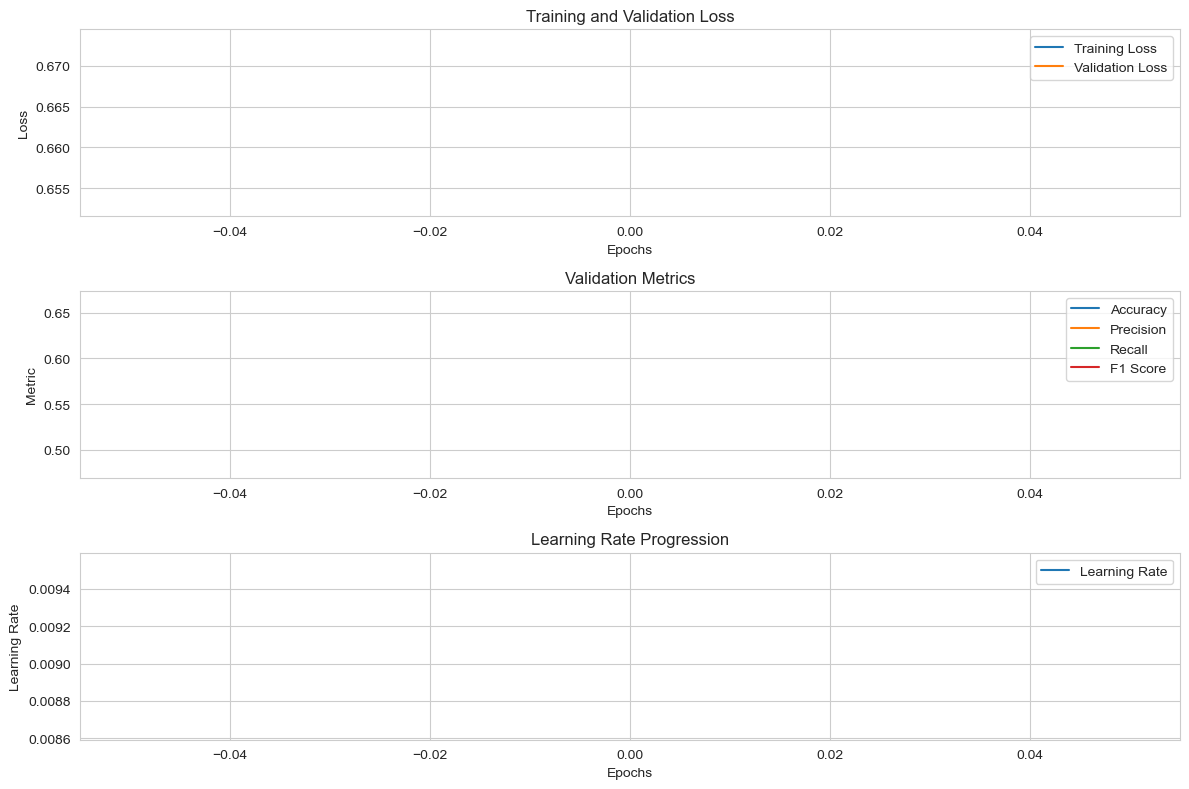

In [20]:
best_model = training_method(model, criterion, optimizer, scheduler, train_dataloader, validation_dataloader, model_config, num_epochs=1, model_name="MLPMixer")

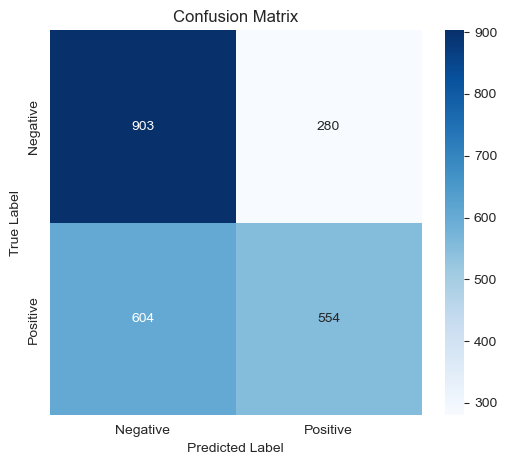

In [21]:
val_accuracy, val_f1, val_loss, val_precision, val_recall = validation_method(criterion, best_model, validation_dataloader, confusion_matrix=True)

# Hyperparameter tuning

In [21]:
import gc


def hyperparameter_tuning(model_class, parameters_grid, epochs, train_dataloader, validation_dataloader, results, model_name="AlexNet"):
    best_model = None
    best_val_loss = np.inf
    for idx in tqdm(range(len(parameters_grid["lr"]))):
        # get params
        lr = parameters_grid["lr"][idx]
        eta_min = parameters_grid["eta_min"][idx]
        weight_decay = random.choice(parameters_grid['weight_decay'])
        model_config = {
            "lr": lr,
            "eta_min": eta_min,
            "weight_decay": weight_decay,
        }
        print(f"Learning rate {lr:.2e} - "
              f"eta_min {eta_min:.2e} - "
              f"weight_decay {weight_decay:.2e}")
        try:
            model = model_class(num_classes=1)
            if model_name =="vgg":
                model.apply(initialize_weights)
            model.to(device)
            
            criterion = BCEWithLogitsLoss()
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer,
                T_0=5,
                T_mult=1,
                eta_min=eta_min,
            )
            
            best_curr_model = training_method(model, criterion, optimizer, scheduler, train_dataloader, validation_dataloader, model_config, num_epochs=epochs, model_name=model_name)
            
            val_accuracy, val_f1, val_loss, val_precision, val_recall = validation_method(criterion, best_curr_model, validation_dataloader, confusion_matrix=True)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = copy.deepcopy(best_curr_model)
            
            result = {
                "lr": lr,
                "eta_min": eta_min,
                "weight_decay": weight_decay,
                "val_loss": val_loss,
                "val_accuracy": val_accuracy,
                "val_precision": val_precision,
                "val_recall": val_recall,
                "val_f1": val_f1,
            }
            results.append(result)
            
        except RuntimeError as e:
            print(f"Error with configuration: {lr=}, {eta_min=}, {weight_decay=}")
            print(f"Error message: {str(e)}")
        
        finally:
            # Reset GPU memory
            print("Resetting GPU memory...")
            torch.cuda.empty_cache()
            gc.collect()
    
    return best_model, results

# AlexNet

In [35]:
param_grid = {
    "lr":       [1e-2, 5e-3, 1e-3, 5e-4, 1e-4],
    "eta_min":  [1e-4, 1e-4, 5e-5, 5e-5, 1e-5],
    "weight_decay": [5e-4, 1e-5, 5e-5]
}


total_combination = len(param_grid['lr'])
epochs = 30
time_per_epoch = 140 # approx

print(f"Total time to hyper tune: {total_combination * epochs * time_per_epoch / 3600:.2f} hours")

Total time to hyper tune: 5.83 hours


In [ ]:
AlexNet_results = []

  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate 1.00e-02 - eta_min 1.00e-04 - weight_decay 1.00e-05
[0, 292/1171] Loss: 0.6956
[0, 584/1171] Loss: 0.6931
[0, 876/1171] Loss: 0.6929
[0, 1168/1171] Loss: 0.6917
New best model with Loss: 0.6904 at epoch 1

Epoch 1/30 - Training Loss: 0.6911 - Validation Loss: 0.6904 - Accuracy: 0.5241 - Precision: 0.5671 - Recall: 0.1606 - F1 Score: 0.2503 - Time: 142.62 - Lr: 9.05e-03
[1, 292/1171] Loss: 0.6867
[1, 584/1171] Loss: 0.6783
[1, 876/1171] Loss: 0.6660
[1, 1168/1171] Loss: 0.6580
New best model with Loss: 0.6092 at epoch 2

Epoch 2/30 - Training Loss: 0.6573 - Validation Loss: 0.6092 - Accuracy: 0.6903 - Precision: 0.6966 - Recall: 0.6623 - F1 Score: 0.6791 - Time: 141.07 - Lr: 6.58e-03
[2, 292/1171] Loss: 0.6005
[2, 584/1171] Loss: 0.5978
[2, 876/1171] Loss: 0.5825
[2, 1168/1171] Loss: 0.5752
New best model with Loss: 0.5253 at epoch 3

Epoch 3/30 - Training Loss: 0.5745 - Validation Loss: 0.5253 - Accuracy: 0.7403 - Precision: 0.6918 - Recall: 0.8566 - F1 Score: 0.7654 - Ti

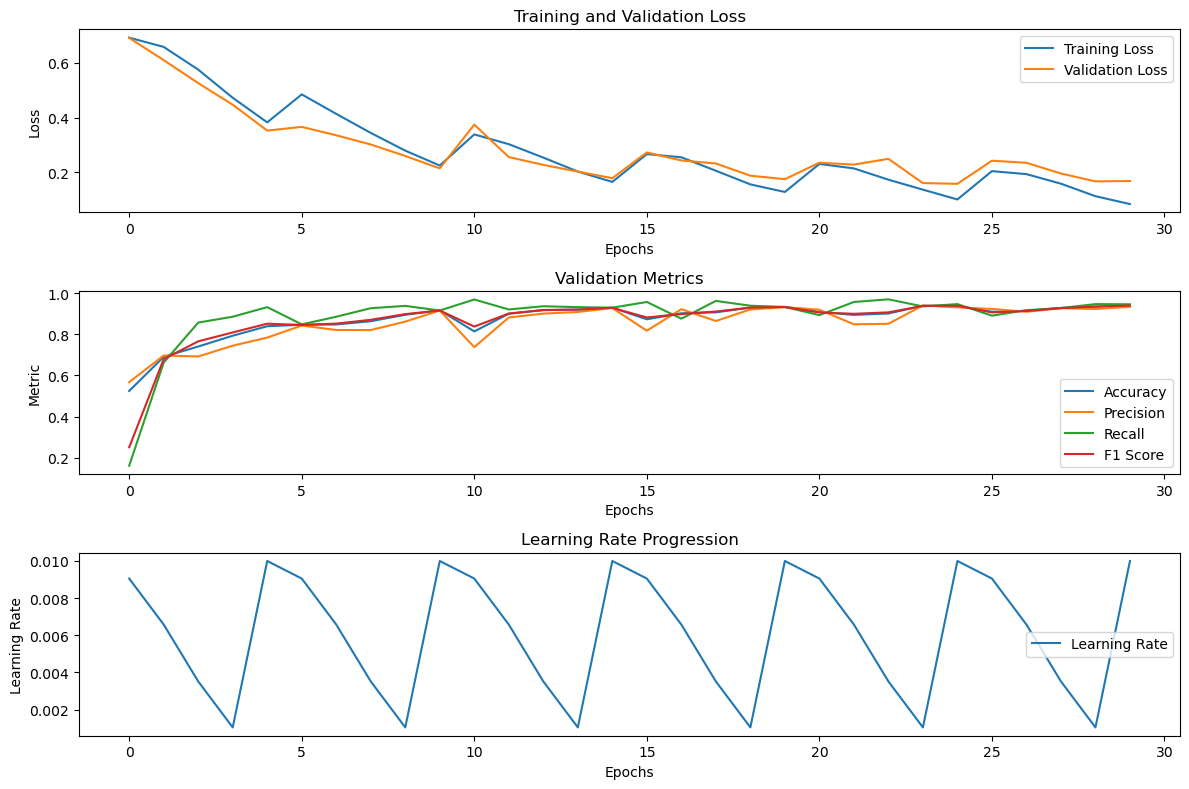

 20%|██        | 1/5 [1:09:49<4:39:19, 4189.93s/it]

Resetting GPU memory...
Learning rate 5.00e-03 - eta_min 1.00e-04 - weight_decay 5.00e-04
[0, 292/1171] Loss: 0.6954
[0, 584/1171] Loss: 0.6934
[0, 876/1171] Loss: 0.6917
[0, 1168/1171] Loss: 0.6884
New best model with Loss: 0.6513 at epoch 1

Epoch 1/30 - Training Loss: 0.6877 - Validation Loss: 0.6513 - Accuracy: 0.6403 - Precision: 0.6308 - Recall: 0.6580 - F1 Score: 0.6441 - Time: 139.17 - Lr: 4.53e-03
[1, 292/1171] Loss: 0.6711
[1, 584/1171] Loss: 0.6620
[1, 876/1171] Loss: 0.6571
[1, 1168/1171] Loss: 0.6475
New best model with Loss: 0.5924 at epoch 2

Epoch 2/30 - Training Loss: 0.6467 - Validation Loss: 0.5924 - Accuracy: 0.6818 - Precision: 0.7135 - Recall: 0.5959 - F1 Score: 0.6494 - Time: 139.08 - Lr: 3.31e-03
[2, 292/1171] Loss: 0.6053
[2, 584/1171] Loss: 0.5900
[2, 876/1171] Loss: 0.5858
[2, 1168/1171] Loss: 0.5750
New best model with Loss: 0.5515 at epoch 3

Epoch 3/30 - Training Loss: 0.5741 - Validation Loss: 0.5515 - Accuracy: 0.7185 - Precision: 0.7206 - Recall: 0.7038

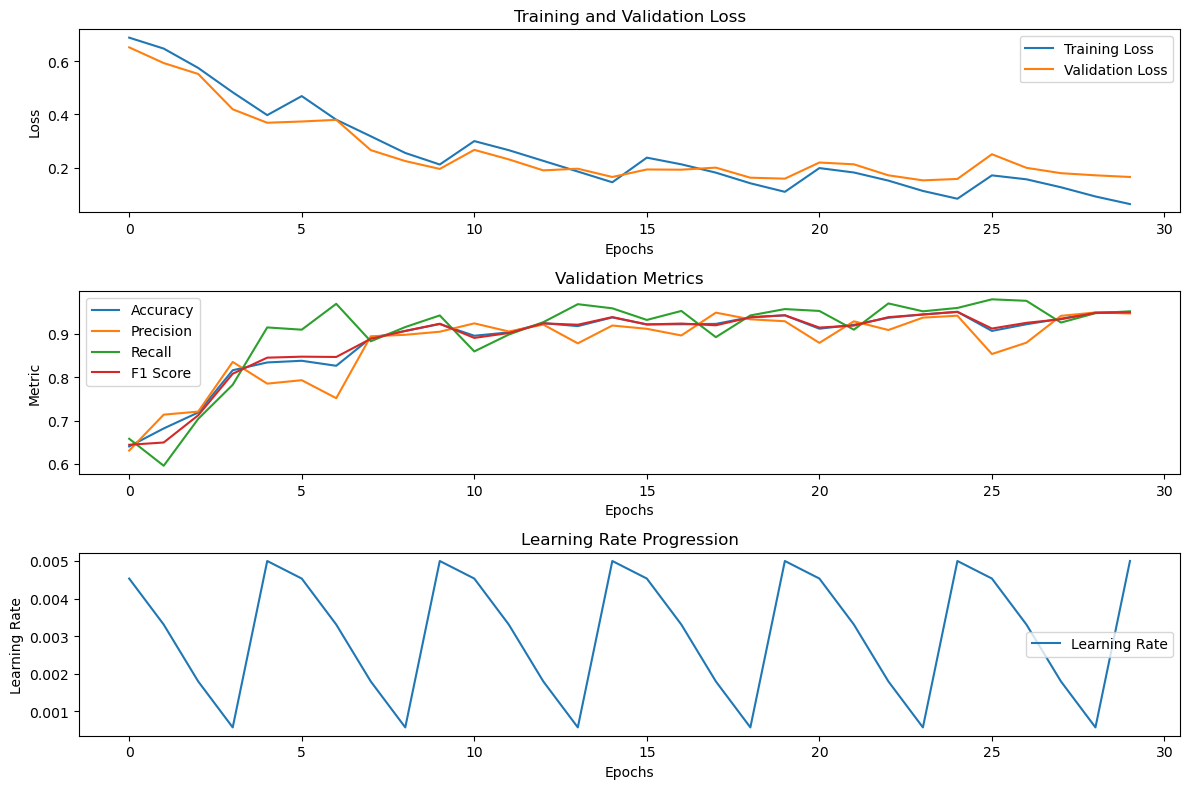

 40%|████      | 2/5 [2:19:25<3:29:04, 4181.38s/it]

Resetting GPU memory...
Learning rate 1.00e-03 - eta_min 5.00e-05 - weight_decay 1.00e-05
[0, 292/1171] Loss: 0.6951
[0, 584/1171] Loss: 0.6942
[0, 876/1171] Loss: 0.6937
[0, 1168/1171] Loss: 0.6933
New best model with Loss: 0.6920 at epoch 1

Epoch 1/30 - Training Loss: 0.6927 - Validation Loss: 0.6920 - Accuracy: 0.4947 - Precision: 0.4947 - Recall: 1.0000 - F1 Score: 0.6619 - Time: 138.70 - Lr: 9.09e-04
[1, 292/1171] Loss: 0.6946
[1, 584/1171] Loss: 0.6928
[1, 876/1171] Loss: 0.6916
[1, 1168/1171] Loss: 0.6895
New best model with Loss: 0.6745 at epoch 2

Epoch 2/30 - Training Loss: 0.6889 - Validation Loss: 0.6745 - Accuracy: 0.6164 - Precision: 0.5782 - Recall: 0.8299 - F1 Score: 0.6816 - Time: 138.50 - Lr: 6.72e-04
[2, 292/1171] Loss: 0.6733
[2, 584/1171] Loss: 0.6688
[2, 876/1171] Loss: 0.6652
[2, 1168/1171] Loss: 0.6590
New best model with Loss: 0.6380 at epoch 3

Epoch 3/30 - Training Loss: 0.6587 - Validation Loss: 0.6380 - Accuracy: 0.6433 - Precision: 0.6118 - Recall: 0.7634

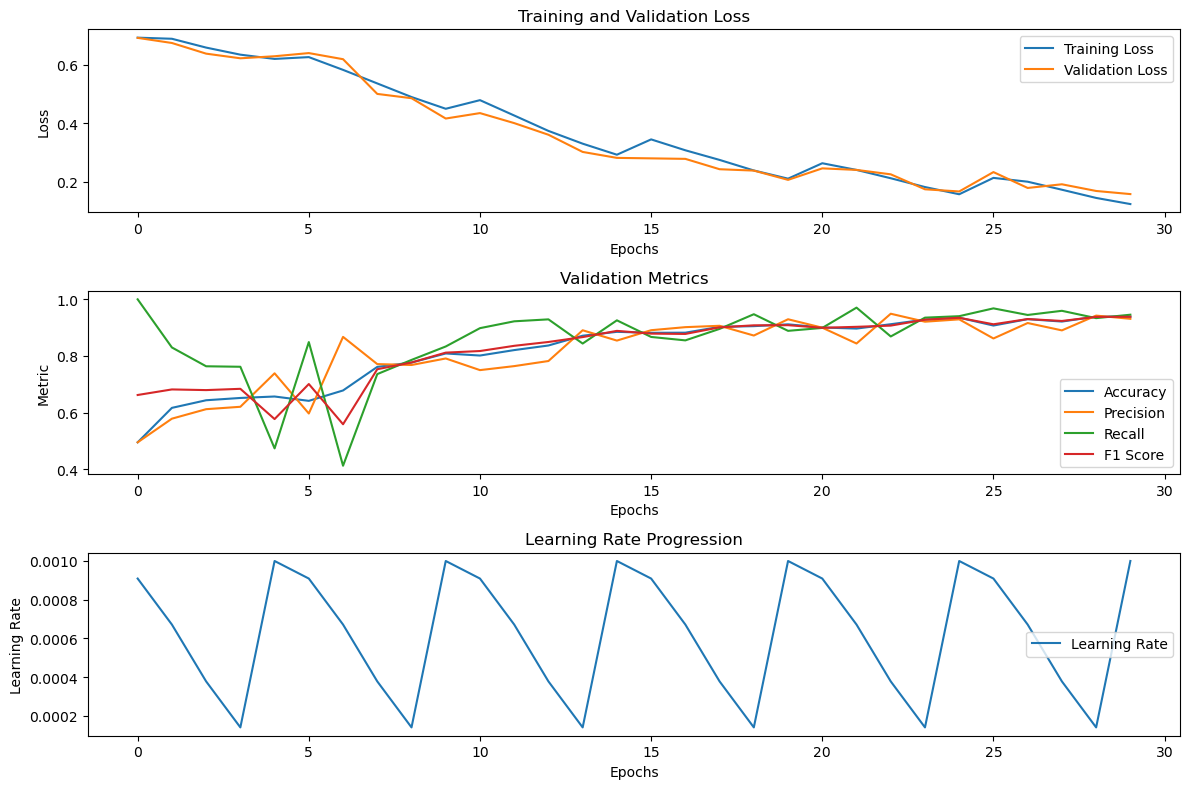

 60%|██████    | 3/5 [3:29:12<2:19:28, 4184.04s/it]

Resetting GPU memory...
Learning rate 5.00e-04 - eta_min 5.00e-05 - weight_decay 5.00e-04
[0, 292/1171] Loss: 0.6955
[0, 584/1171] Loss: 0.6942
[0, 876/1171] Loss: 0.6939
[0, 1168/1171] Loss: 0.6936
New best model with Loss: 0.6927 at epoch 1

Epoch 1/30 - Training Loss: 0.6930 - Validation Loss: 0.6927 - Accuracy: 0.5066 - Precision: 0.6667 - Recall: 0.0052 - F1 Score: 0.0103 - Time: 138.68 - Lr: 4.57e-04
[1, 292/1171] Loss: 0.6952
[1, 584/1171] Loss: 0.6940
[1, 876/1171] Loss: 0.6935
[1, 1168/1171] Loss: 0.6932
New best model with Loss: 0.6920 at epoch 2

Epoch 2/30 - Training Loss: 0.6926 - Validation Loss: 0.6920 - Accuracy: 0.5903 - Precision: 0.5623 - Recall: 0.7755 - F1 Score: 0.6519 - Time: 137.86 - Lr: 3.45e-04
[2, 292/1171] Loss: 0.6944
[2, 584/1171] Loss: 0.6931
[2, 876/1171] Loss: 0.6927
[2, 1168/1171] Loss: 0.6924
New best model with Loss: 0.6906 at epoch 3

Epoch 3/30 - Training Loss: 0.6918 - Validation Loss: 0.6906 - Accuracy: 0.6006 - Precision: 0.5791 - Recall: 0.7047

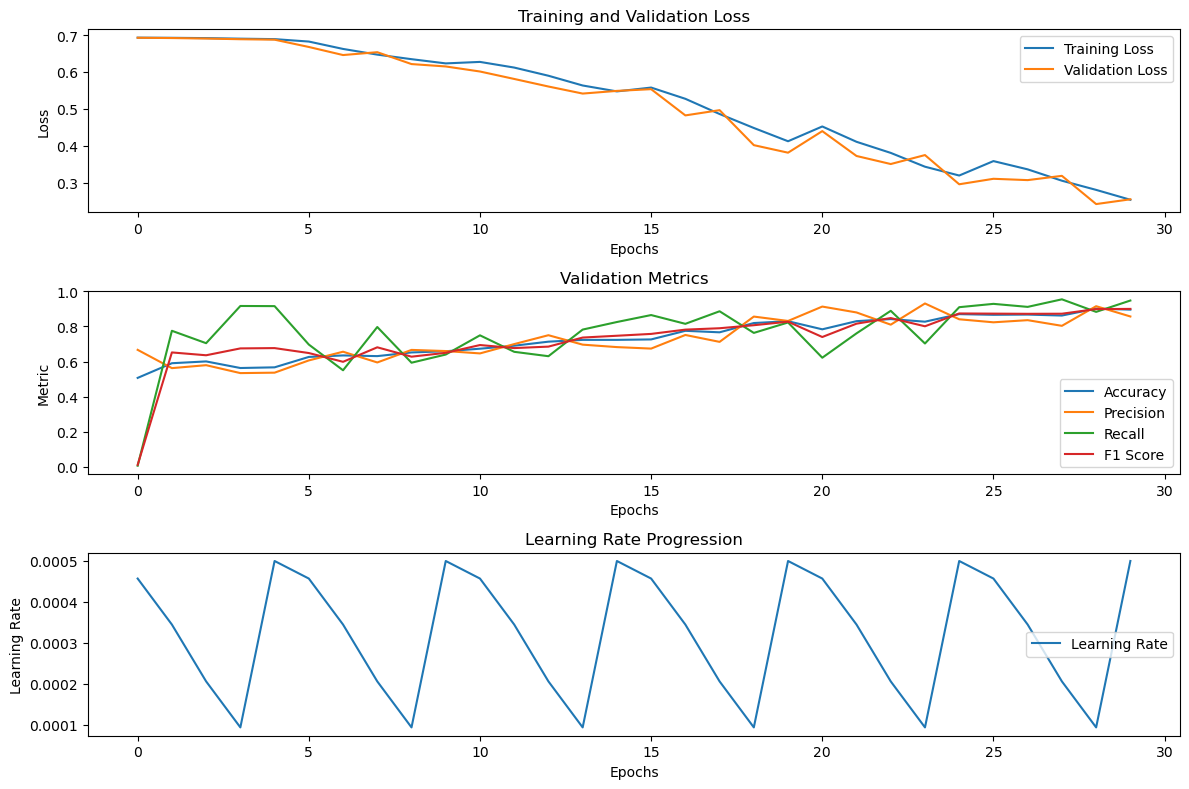

 80%|████████  | 4/5 [4:38:25<1:09:31, 4171.76s/it]

Resetting GPU memory...
Learning rate 1.00e-04 - eta_min 1.00e-05 - weight_decay 5.00e-05
[0, 292/1171] Loss: 0.6956
[0, 584/1171] Loss: 0.6943
[0, 876/1171] Loss: 0.6939
[0, 1168/1171] Loss: 0.6937
New best model with Loss: 0.6931 at epoch 1

Epoch 1/30 - Training Loss: 0.6931 - Validation Loss: 0.6931 - Accuracy: 0.5177 - Precision: 0.5721 - Recall: 0.0993 - F1 Score: 0.1692 - Time: 137.89 - Lr: 9.14e-05
[1, 292/1171] Loss: 0.6955
[1, 584/1171] Loss: 0.6943
[1, 876/1171] Loss: 0.6939
[1, 1168/1171] Loss: 0.6937
New best model with Loss: 0.6931 at epoch 2

Epoch 2/30 - Training Loss: 0.6931 - Validation Loss: 0.6931 - Accuracy: 0.5058 - Precision: 0.5714 - Recall: 0.0035 - F1 Score: 0.0069 - Time: 138.00 - Lr: 6.89e-05
[2, 292/1171] Loss: 0.6955
[2, 584/1171] Loss: 0.6943
[2, 876/1171] Loss: 0.6939
[2, 1168/1171] Loss: 0.6937
New best model with Loss: 0.6930 at epoch 3

Epoch 3/30 - Training Loss: 0.6931 - Validation Loss: 0.6930 - Accuracy: 0.5049 - Precision: 0.3333 - Recall: 0.0009

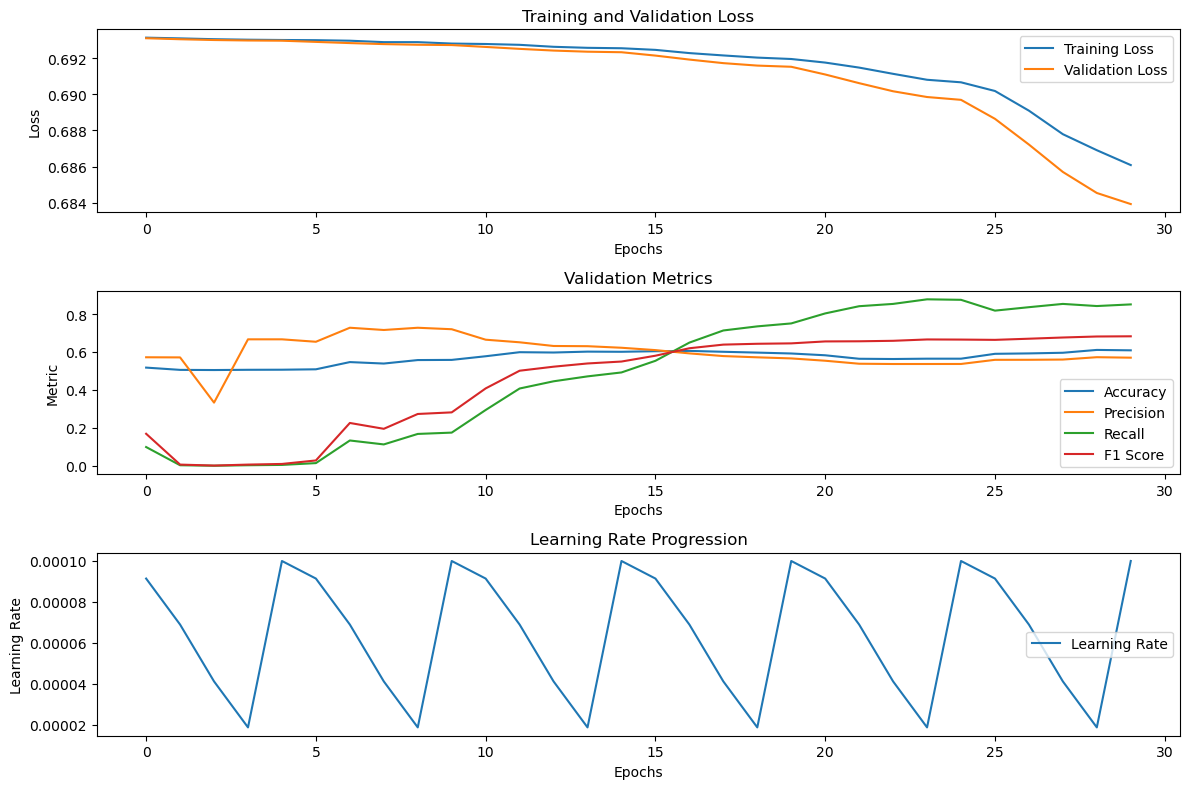

100%|██████████| 5/5 [5:47:30<00:00, 4170.08s/it]  

Resetting GPU memory...


In [36]:
best_AlexNet_model, AlexNet_results = hyperparameter_tuning(AlexNet, param_grid, epochs, train_dataloader, validation_dataloader, AlexNet_results, model_name="AlexNet")

In [37]:
import pandas as pd

results_df = pd.DataFrame(AlexNet_results)
results_df.fillna("", inplace=True)
results_df.sort_values(by="val_loss", inplace=True)
results_df

,lr,eta_min,weight_decay,val_loss,val_accuracy,val_precision,val_recall,val_f1
1,0.0050,0.00010,0.00050,0.152700,0.944468,0.937075,0.951641,0.944302
2,0.0010,0.00005,0.00001,0.157307,0.938488,0.931122,0.945596,0.938303
0,0.0100,0.00010,0.00001,0.158255,0.938488,0.930390,0.946459,0.938356
3,0.0005,0.00005,0.00050,0.242085,0.902179,0.915846,0.883420,0.899341
4,0.0001,0.00001,0.00005,0.683923,0.608714,0.570023,0.850604,0.682606


# VGG

In [21]:
param_grid = {
    "lr":       [1e-2, 1e-3, 1e-4],
    "eta_min":  [1e-3, 1e-4, 1e-5],
    "weight_decay": [1e-5]
}


total_combination = len(param_grid['lr'])
epochs = 15
time_per_epoch = 240 # approx

print(f"Total time to hyper tune: {total_combination * epochs * time_per_epoch / 3600:.2f} hours")

[2025-02-09 12:55:59]  Total time to hyper tune: 3.00 hours


In [22]:
VGG_results = []

  0%|          | 0/3 [00:00<?, ?it/s]

[2025-02-09 12:56:00]  Learning rate 1.00e-02 - eta_min 1.00e-03 - weight_decay 1.00e-05
[2025-02-09 12:57:00]  [0, 292/1171] Loss: 0.6980
[2025-02-09 12:57:58]  [0, 584/1171] Loss: 0.6958
[2025-02-09 12:58:56]  [0, 876/1171] Loss: 0.6948
[2025-02-09 12:59:54]  [0, 1168/1171] Loss: 0.6946
[2025-02-09 13:00:06]  New best model with Loss: 0.6938 at epoch 1
[2025-02-09 13:00:06]  
Epoch 1/15 - Training Loss: 0.6940 - Validation Loss: 0.6938 - Accuracy: 0.5053 - Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Time: 245.07 - Lr: 9.14e-03
[2025-02-09 13:01:05]  [1, 292/1171] Loss: 0.6965
[2025-02-09 13:02:04]  [1, 584/1171] Loss: 0.6953
[2025-02-09 13:03:03]  [1, 876/1171] Loss: 0.6948
[2025-02-09 13:04:03]  [1, 1168/1171] Loss: 0.6946
[2025-02-09 13:04:15]  New best model with Loss: 0.6903 at epoch 2
[2025-02-09 13:04:15]  
Epoch 2/15 - Training Loss: 0.6940 - Validation Loss: 0.6903 - Accuracy: 0.5485 - Precision: 0.5691 - Recall: 0.3592 - F1 Score: 0.4404 - Time: 248.78 - Lr: 6.89

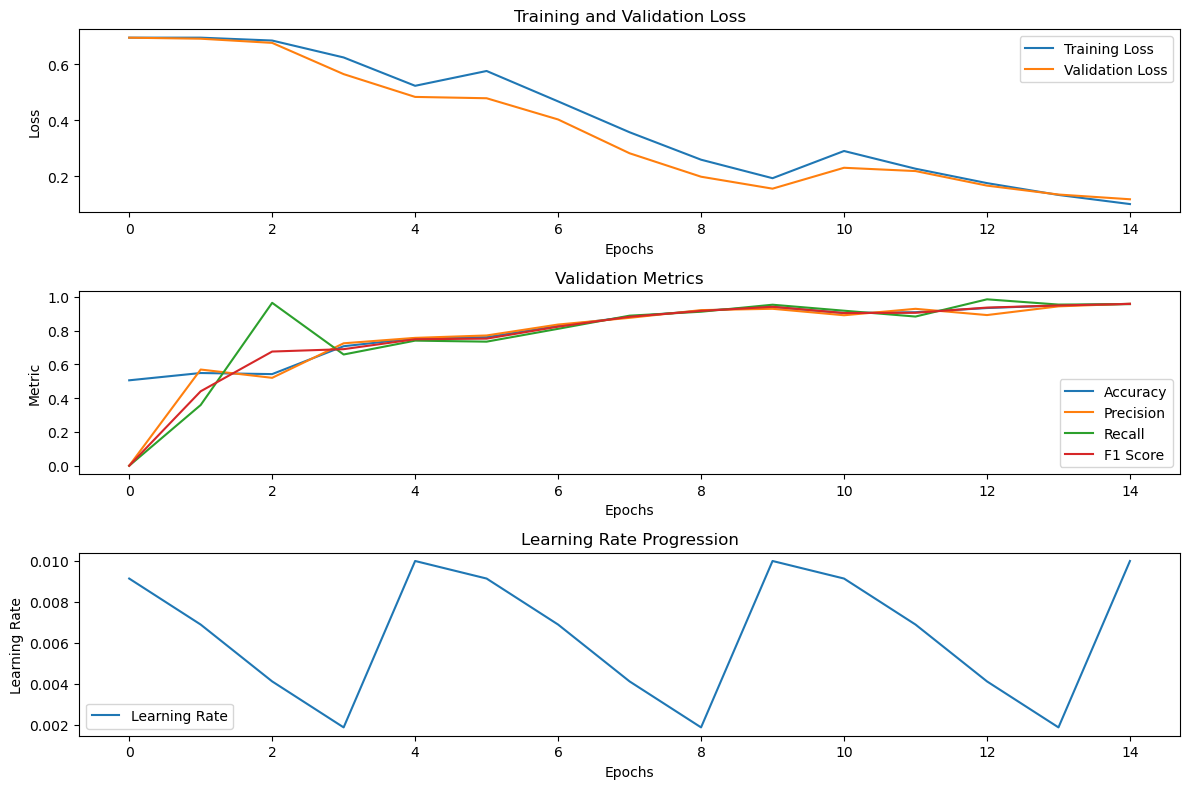

 33%|███▎      | 1/3 [1:00:54<2:01:49, 3654.70s/it]

[2025-02-09 13:56:54]  Resetting GPU memory...
[2025-02-09 13:56:55]  Learning rate 1.00e-03 - eta_min 1.00e-04 - weight_decay 1.00e-05
[2025-02-09 13:57:55]  [0, 292/1171] Loss: 0.6946
[2025-02-09 13:58:54]  [0, 584/1171] Loss: 0.6892
[2025-02-09 13:59:52]  [0, 876/1171] Loss: 0.6840
[2025-02-09 14:00:50]  [0, 1168/1171] Loss: 0.6774
[2025-02-09 14:01:02]  New best model with Loss: 0.6289 at epoch 1
[2025-02-09 14:01:02]  
Epoch 1/15 - Training Loss: 0.6767 - Validation Loss: 0.6289 - Accuracy: 0.6523 - Precision: 0.6340 - Recall: 0.7029 - F1 Score: 0.6667 - Time: 246.37 - Lr: 9.14e-04
[2025-02-09 14:02:00]  [1, 292/1171] Loss: 0.6517
[2025-02-09 14:02:59]  [1, 584/1171] Loss: 0.6391
[2025-02-09 14:03:57]  [1, 876/1171] Loss: 0.6292
[2025-02-09 14:04:55]  [1, 1168/1171] Loss: 0.6239
[2025-02-09 14:05:07]  New best model with Loss: 0.5652 at epoch 2
[2025-02-09 14:05:07]  
Epoch 2/15 - Training Loss: 0.6233 - Validation Loss: 0.5652 - Accuracy: 0.6959 - Precision: 0.6963 - Recall: 0.68

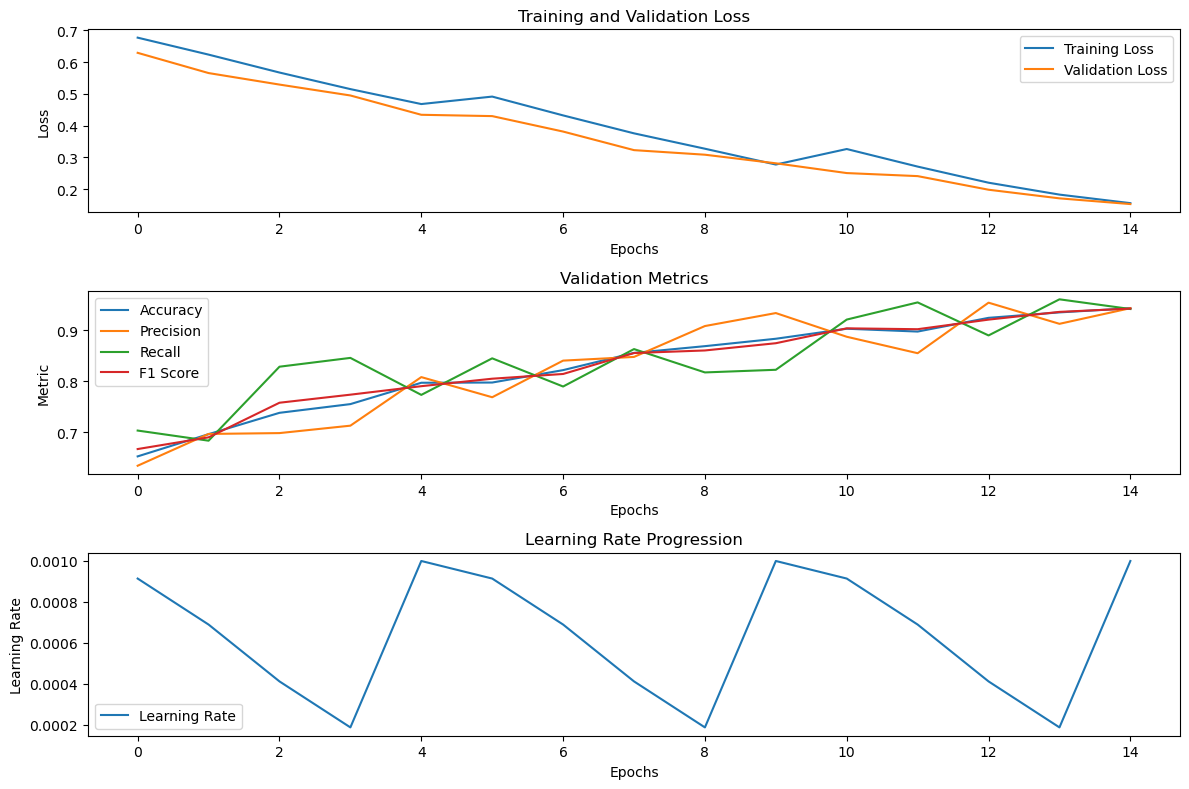

 67%|██████▋   | 2/3 [2:00:57<1:00:23, 3623.92s/it]

[2025-02-09 14:56:57]  Resetting GPU memory...
[2025-02-09 14:56:57]  Learning rate 1.00e-04 - eta_min 1.00e-05 - weight_decay 1.00e-05
[2025-02-09 14:57:54]  [0, 292/1171] Loss: 0.6989
[2025-02-09 14:58:51]  [0, 584/1171] Loss: 0.6943
[2025-02-09 14:59:47]  [0, 876/1171] Loss: 0.6921
[2025-02-09 15:00:43]  [0, 1168/1171] Loss: 0.6893
[2025-02-09 15:00:54]  New best model with Loss: 0.6673 at epoch 1
[2025-02-09 15:00:54]  
Epoch 1/15 - Training Loss: 0.6887 - Validation Loss: 0.6673 - Accuracy: 0.6301 - Precision: 0.6619 - Recall: 0.5155 - F1 Score: 0.5796 - Time: 236.04 - Lr: 9.14e-05
[2025-02-09 15:01:50]  [1, 292/1171] Loss: 0.6753
[2025-02-09 15:02:46]  [1, 584/1171] Loss: 0.6669
[2025-02-09 15:03:43]  [1, 876/1171] Loss: 0.6635
[2025-02-09 15:04:39]  [1, 1168/1171] Loss: 0.6615
[2025-02-09 15:04:50]  New best model with Loss: 0.6389 at epoch 2
[2025-02-09 15:04:50]  
Epoch 2/15 - Training Loss: 0.6608 - Validation Loss: 0.6389 - Accuracy: 0.6382 - Precision: 0.6193 - Recall: 0.69

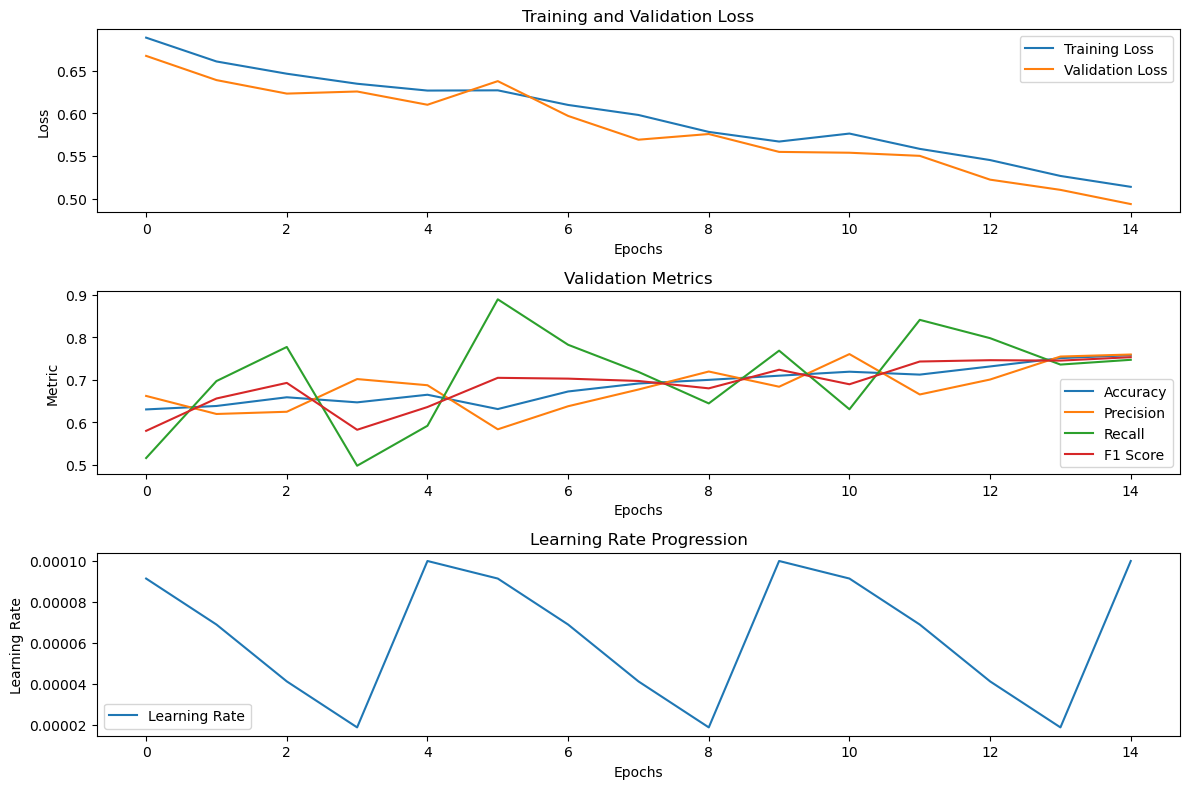

100%|██████████| 3/3 [3:00:45<00:00, 3615.06s/it]  

[2025-02-09 15:56:45]  Resetting GPU memory...


In [23]:
best_VGG_model, VGG_results = hyperparameter_tuning(VGG, param_grid, epochs, train_dataloader, validation_dataloader, VGG_results, model_name="vgg")

In [25]:
import pandas as pd

results_df = pd.DataFrame(VGG_results)
results_df.fillna("", inplace=True)
results_df.sort_values(by="val_loss", inplace=True)
results_df

,lr,eta_min,weight_decay,val_loss,val_accuracy,val_precision,val_recall,val_f1
0,0.0100,0.00100,0.00001,0.117521,0.957710,0.958442,0.955959,0.957198
1,0.0010,0.00010,0.00001,0.152698,0.942760,0.942907,0.941278,0.942092
2,0.0001,0.00001,0.00001,0.493643,0.757796,0.759438,0.746978,0.753156


# MLP Mixer

In [22]:
param_grid = {
    "lr":       [1e-2, 1e-3, 1e-4],
    "eta_min":  [1e-3, 1e-4, 1e-5],
    "weight_decay": [1e-4, 1e-5]
}


total_combination = len(param_grid['lr'])
epochs = 15
time_per_epoch = 230 # approx

print(f"Total time to hyper tune: {total_combination * epochs * time_per_epoch / 3600:.2f} hours")

[2025-02-10 10:49:21]  Total time to hyper tune: 2.88 hours


In [23]:
MLP_Mixer_results = []

  0%|          | 0/3 [00:00<?, ?it/s]

[2025-02-10 10:49:30]  Learning rate 1.00e-02 - eta_min 1.00e-03 - weight_decay 1.00e-04
[2025-02-10 10:50:30]  [0, 292/1171] Loss: 0.6959
[2025-02-10 10:51:28]  [0, 584/1171] Loss: 0.6890
[2025-02-10 10:52:26]  [0, 876/1171] Loss: 0.6855
[2025-02-10 10:53:25]  [0, 1168/1171] Loss: 0.6844
[2025-02-10 10:53:36]  New best model with Loss: 0.6520 at epoch 1
[2025-02-10 10:53:36]  
Epoch 1/15 - Training Loss: 0.6838 - Validation Loss: 0.6520 - Accuracy: 0.6305 - Precision: 0.6518 - Recall: 0.5432 - F1 Score: 0.5926 - Time: 245.27 - Lr: 9.14e-03
[2025-02-10 10:54:34]  [1, 292/1171] Loss: 0.6555
[2025-02-10 10:55:33]  [1, 584/1171] Loss: 0.6541
[2025-02-10 10:56:33]  [1, 876/1171] Loss: 0.6517
[2025-02-10 10:57:31]  [1, 1168/1171] Loss: 0.6428
[2025-02-10 10:57:42]  New best model with Loss: 0.5662 at epoch 2
[2025-02-10 10:57:42]  
Epoch 2/15 - Training Loss: 0.6420 - Validation Loss: 0.5662 - Accuracy: 0.7070 - Precision: 0.6947 - Recall: 0.7271 - F1 Score: 0.7105 - Time: 245.86 - Lr: 6.89

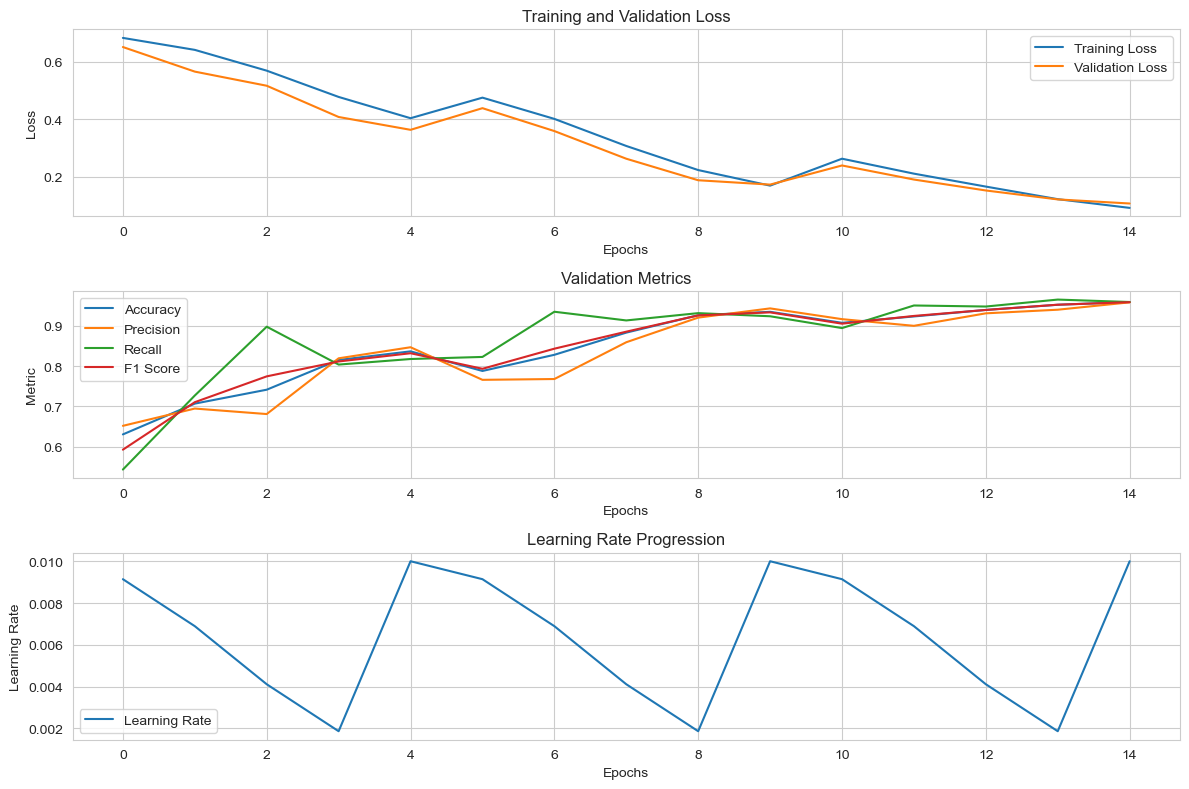

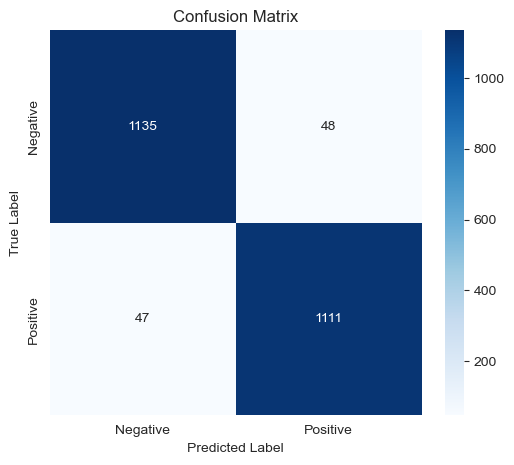

[2025-02-10 11:50:03]  Resetting GPU memory...


 33%|███▎      | 1/3 [1:00:33<2:01:06, 3633.36s/it]

[2025-02-10 11:50:03]  Learning rate 1.00e-03 - eta_min 1.00e-04 - weight_decay 1.00e-05
[2025-02-10 11:51:03]  [0, 292/1171] Loss: 0.6918
[2025-02-10 11:52:00]  [0, 584/1171] Loss: 0.6829
[2025-02-10 11:52:57]  [0, 876/1171] Loss: 0.6766
[2025-02-10 11:53:54]  [0, 1168/1171] Loss: 0.6686
[2025-02-10 11:54:05]  New best model with Loss: 0.6068 at epoch 1
[2025-02-10 11:54:05]  
Epoch 1/15 - Training Loss: 0.6680 - Validation Loss: 0.6068 - Accuracy: 0.6681 - Precision: 0.6962 - Recall: 0.5838 - F1 Score: 0.6350 - Time: 240.88 - Lr: 9.14e-04
[2025-02-10 11:55:02]  [1, 292/1171] Loss: 0.6366
[2025-02-10 11:55:59]  [1, 584/1171] Loss: 0.6339
[2025-02-10 11:56:56]  [1, 876/1171] Loss: 0.6240
[2025-02-10 11:57:53]  [1, 1168/1171] Loss: 0.6195
[2025-02-10 11:58:05]  New best model with Loss: 0.5789 at epoch 2
[2025-02-10 11:58:05]  
Epoch 2/15 - Training Loss: 0.6191 - Validation Loss: 0.5789 - Accuracy: 0.7010 - Precision: 0.7189 - Recall: 0.6494 - F1 Score: 0.6824 - Time: 239.89 - Lr: 6.89

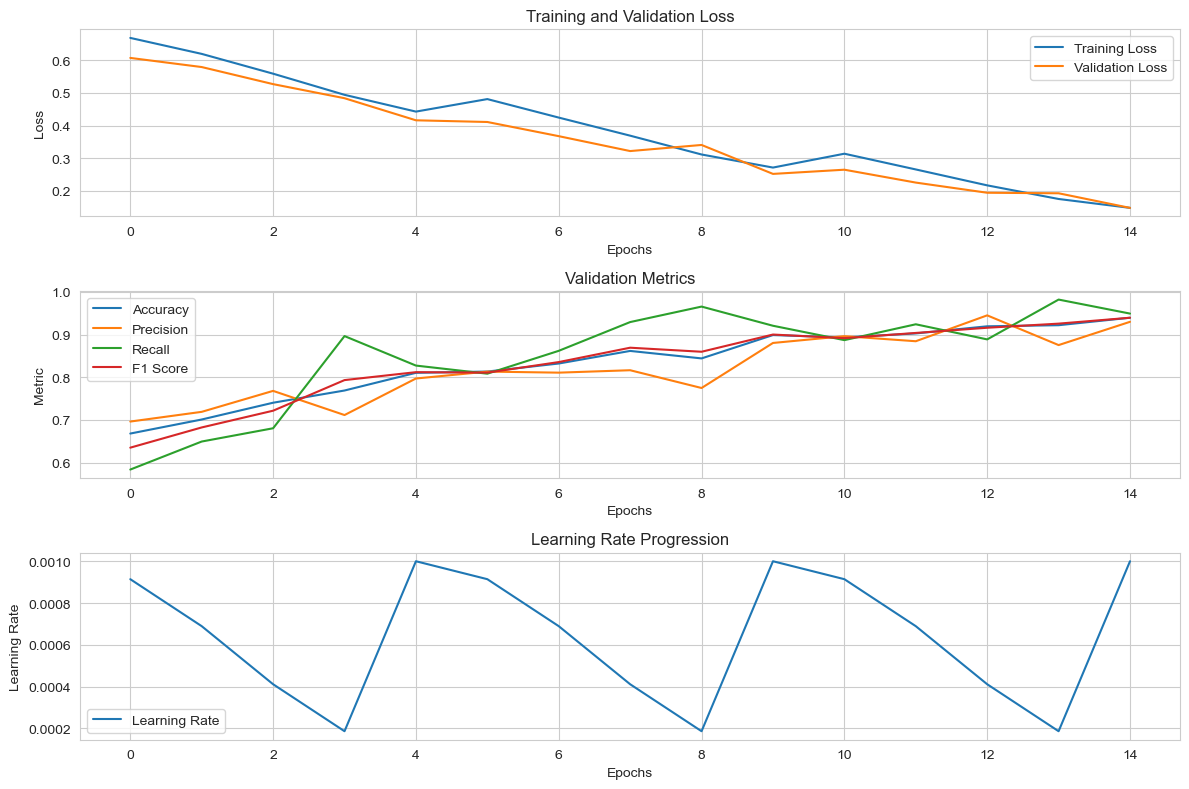

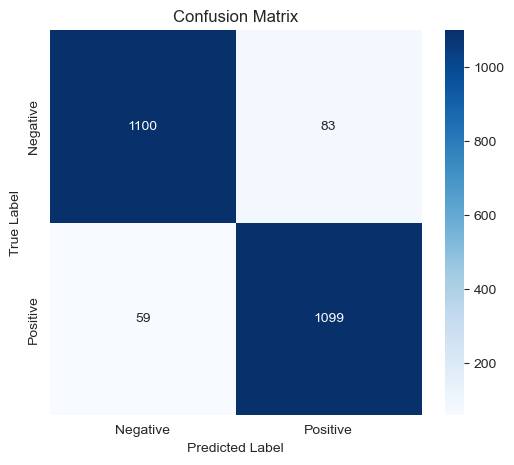

 67%|██████▋   | 2/3 [2:01:07<1:00:34, 3634.01s/it]

[2025-02-10 12:50:38]  Resetting GPU memory...
[2025-02-10 12:50:38]  Learning rate 1.00e-04 - eta_min 1.00e-05 - weight_decay 1.00e-04
[2025-02-10 12:51:38]  [0, 292/1171] Loss: 0.6977
[2025-02-10 12:52:37]  [0, 584/1171] Loss: 0.6921
[2025-02-10 12:53:35]  [0, 876/1171] Loss: 0.6868
[2025-02-10 12:54:34]  [0, 1168/1171] Loss: 0.6835
[2025-02-10 12:54:46]  New best model with Loss: 0.6553 at epoch 1
[2025-02-10 12:54:46]  
Epoch 1/15 - Training Loss: 0.6830 - Validation Loss: 0.6553 - Accuracy: 0.6331 - Precision: 0.6866 - Recall: 0.4750 - F1 Score: 0.5615 - Time: 246.86 - Lr: 9.14e-05
[2025-02-10 12:55:45]  [1, 292/1171] Loss: 0.6608
[2025-02-10 12:56:44]  [1, 584/1171] Loss: 0.6588
[2025-02-10 12:57:43]  [1, 876/1171] Loss: 0.6564
[2025-02-10 12:58:41]  [1, 1168/1171] Loss: 0.6547
[2025-02-10 12:58:53]  New best model with Loss: 0.6326 at epoch 2
[2025-02-10 12:58:53]  
Epoch 2/15 - Training Loss: 0.6541 - Validation Loss: 0.6326 - Accuracy: 0.6506 - Precision: 0.6789 - Recall: 0.55

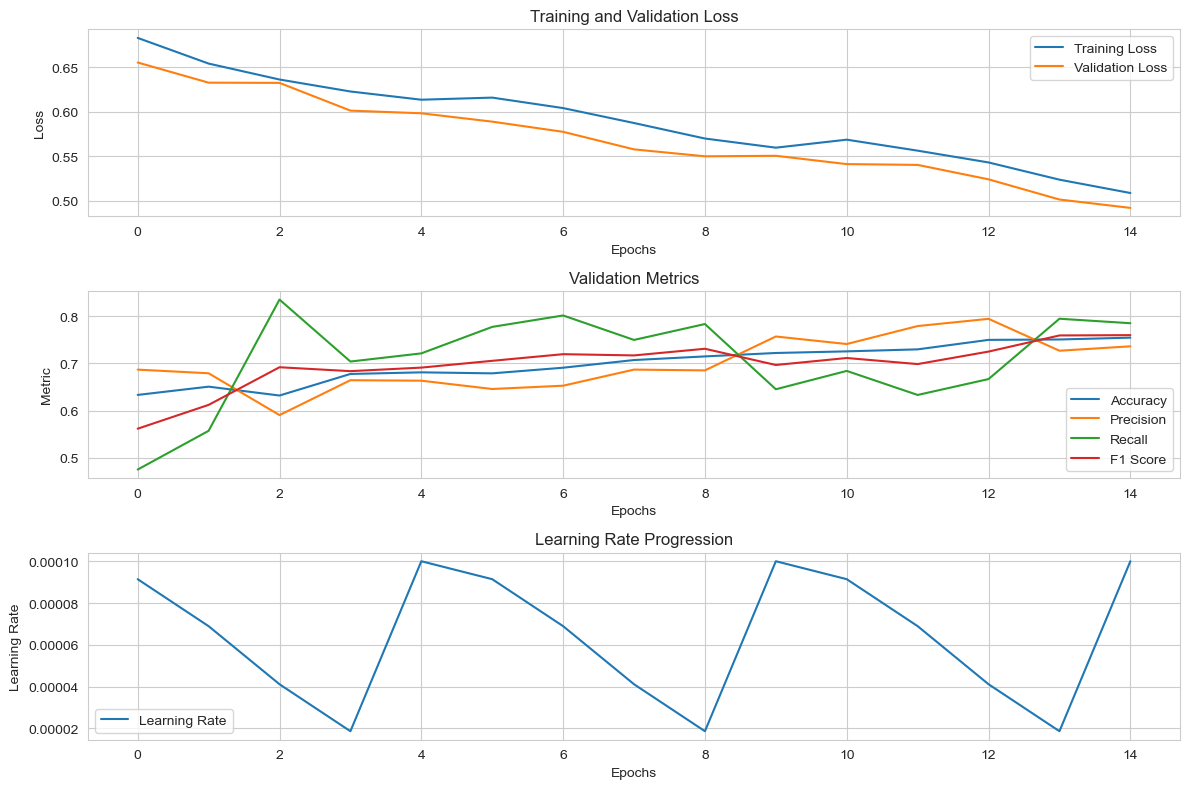

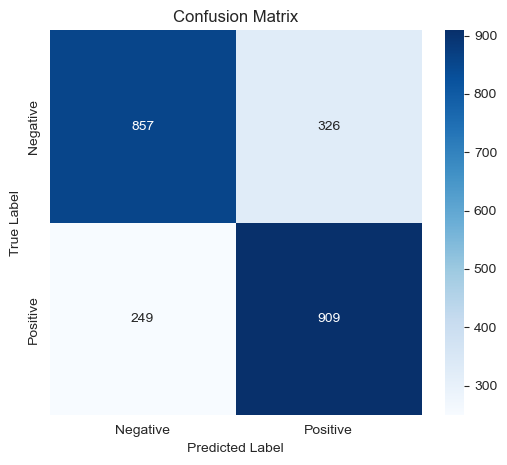

[2025-02-10 13:51:19]  Resetting GPU memory...


100%|██████████| 3/3 [3:01:49<00:00, 3636.59s/it]  


In [24]:
best_MLP_Mixer_model, MLP_Mixer_results = hyperparameter_tuning(VGG, param_grid, epochs, train_dataloader, validation_dataloader, MLP_Mixer_results, model_name="vgg")